### How practical are open-source, academic beat & tempo analysis toolkits for Music Production
* Percussive instrumentation have different attack times, how do beat tracking results vary with analysis parameters?
* Does Harmonic-Percussive Source Separation (HPSS) improve the accuracy of tempo & beat positions?
* How does the SuperFlux onset detection algorithm perform?

### Method
From `/Applications/Ableton\ Live\ 9\ Standard.app/Contents/App-Resources/Core\ Library/Samples/Drums/Kick`, we traverse a folder of 132 different kick drum hits and create audio files of 32 kick hits timed at 128 BPM in 4/4 time. We then analyse the tempo using librosa & madmon. Print variance of results at different points in the hyperparameter space.

### Results
`hop_length` is the hyperparameter which makes the most difference. The tempo accuracy varies with `hop_length`, with `32` being the sweet spot on these simple kick patterns. This corresponds to sub-millisecond temporal resolution @ `48000Hz`Hz.  On the other hand, `fftsize` on the range `[512,4096]` had no impact.

HPSS had no measurable impact on the results with the default margin (IOHAVOCTODO, widen margin to 5+). Given the single instrument, monophonic nature of the audio, HPSS may not have "more to contribute", in contrast with decomposing full-audio mixtures with HPSS.

In [3]:
import os
import random
import pickle
import numpy as np
import librosa
import riddim_utils
from imp import reload
reload(riddim_utils)

import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
# Generate a space of hop x fft window size
hop = np.exp2(range(4, 15)).astype(np.int64)
print(hop)
fft = np.exp2(range(5, 16)).astype(np.int64)
print(fft)

args = []
for i in range(len(hop)):
    for j in range(i, len(fft)):
        args.append((hop[i], fft[j]))

# SuperFlux parameters are taken directly from the paper
lag = 2
n_mels = 138
fmin = 27.5
fmax = 16000.
max_size = 3

def computeTempo(y_path, y, sr, hop_length, fftsize):

    # percussive - harmonic separation
    D = librosa.stft(y, n_fft=fftsize, hop_length=hop_length)
    D_harm, D_perc = librosa.decompose.hpss(D)
    y_perc = librosa.istft(D_perc, hop_length=hop_length)
    y_perc = y_perc / np.max(np.abs(y_perc), axis=0)

    # superflux - regular
    # The paper uses a log-frequency representation, but for simplicity, we'll use a Mel spectrogram instead.
    S = librosa.feature.melspectrogram(y, sr=sr, n_fft=fftsize, hop_length=hop_length,
                                   fmin=fmin, fmax=fmax, n_mels=n_mels)
    odf_sf = librosa.onset.onset_strength(S=librosa.logamplitude(S), 
                                          sr=sr,hop_length=hop_length, lag=lag, max_size=max_size)


    # superflux - percussive - harmonic spearation
    S = librosa.feature.melspectrogram(y_perc, sr=sr, n_fft=fftsize, hop_length=hop_length,
                                   fmin=fmin, fmax=fmax, n_mels=n_mels)
    odf_sf_perc = librosa.onset.onset_strength(S=librosa.logamplitude(S), 
                                               sr=sr,hop_length=hop_length, lag=lag, max_size=max_size)
    
    # librosa garden-variety tempo analysis
    try:
        lr_tempo, beat_frames         = librosa.beat.beat_track(y, sr=sr, hop_length=hop_length)
    except IndexError:
        lr_tempo = 0.0
    # librosa garden-variety tempo analysis on HPSS separated percussive component
    try:
        lr_tempo_perc, beat_frames    = librosa.beat.beat_track(y_perc, sr=sr, hop_length=hop_length)
    except IndexError:
        lr_tempo_perc = 0.0
        
    # librosa garden-variety tempo analysis on Superflux onset envelope        
    try:
        lr_tempo_sf, beat_frames      = librosa.beat.beat_track(onset_envelope=odf_sf, sr=sr, hop_length=hop_length)
    except IndexError:
        lr_tempo_sf = 0.0
        
    # librosa garden-variety tempo analysis on Superflux onset envelope
    try:
        lr_tempo_sf_perc, beat_frames = librosa.beat.beat_track(onset_envelope=odf_sf_perc, sr=sr, hop_length=hop_length)
    except IndexError:
        lr_tempo_sf_perc = 0.0
    
    # DEBUG
    print(y_path + ":  (" + str(hop_length) + "," + str(fftsize) + ")")
    print("tempo, hpss, sf tempo, sf hpss: " + 
          str(lr_tempo) + " " + 
          str(lr_tempo_perc) + " " + 
          str(lr_tempo_sf) + " " + 
          str(lr_tempo_sf_perc))
    
    return lr_tempo, lr_tempo_perc, lr_tempo_sf, lr_tempo_sf_perc

[   16    32    64   128   256   512  1024  2048  4096  8192 16384]
[   32    64   128   256   512  1024  2048  4096  8192 16384 32768]


In [ ]:
import multiprocessing as mp

def cube(x):
    return x**3
    
pool = mp.Pool(processes=4)
results = [pool.apply_async(cube, args=(x,)) for x in range(1,17)]
output = [p.get() for p in results]
print(output)

##################################################


bpm = 128
nb_beats = 16
sr = 48000

hop_length = 32
fftsize = 1024
ableton_kicks_path = "/home/iorife/github/Investigaciones/Drums/Kick/"

def getAllTempos(y_44_path):
    y_44, sr = librosa.load(y_44_path, mono=True)
    tempi = [computeTempo(y_44_path, y_44, sr, hop, fft) for hop, fft in args]
    return (y_44_path, tempi)


riddim_analysis_44_files = []
for kick_sample in os.listdir(ableton_kicks_path):
    if kick_sample.endswith('.wav'):
        kick_sample_path = os.path.join(ableton_kicks_path, kick_sample)
        y_kick_sample, sr = librosa.load(kick_sample_path, mono=True)
        
        # Synthesize 4/4 kick file
        y_44 = riddim_utils.createFourOnTheFloor(bpm=bpm, nb_beats=nb_beats, sr=sr, sample=y_kick_sample)
        y_44_path = "44_{0}".format(kick_sample)
        librosa.output.write_wav(y_44_path, y_44, sr)
        riddim_analysis_44_files.append(y_44_path)
print(riddim_analysis_44_files)
        
pool = mp.Pool(processes=8)
results = [pool.apply_async(getAllTempos, args=(afile,)) for afile in riddim_analysis_44_files]
all_files_results = dict([p.get() for p in results])

# Save results
with open('all_files_results.pickle', 'wb') as handle:
    pickle.dump(all_files_results, handle, protocol=pickle.HIGHEST_PROTOCOL)

# Test 
with open('all_files_results.pickle', 'rb') as handle:
    b = pickle.load(handle)

print(all_files_results == b)
print("done")

132
(66, 4)


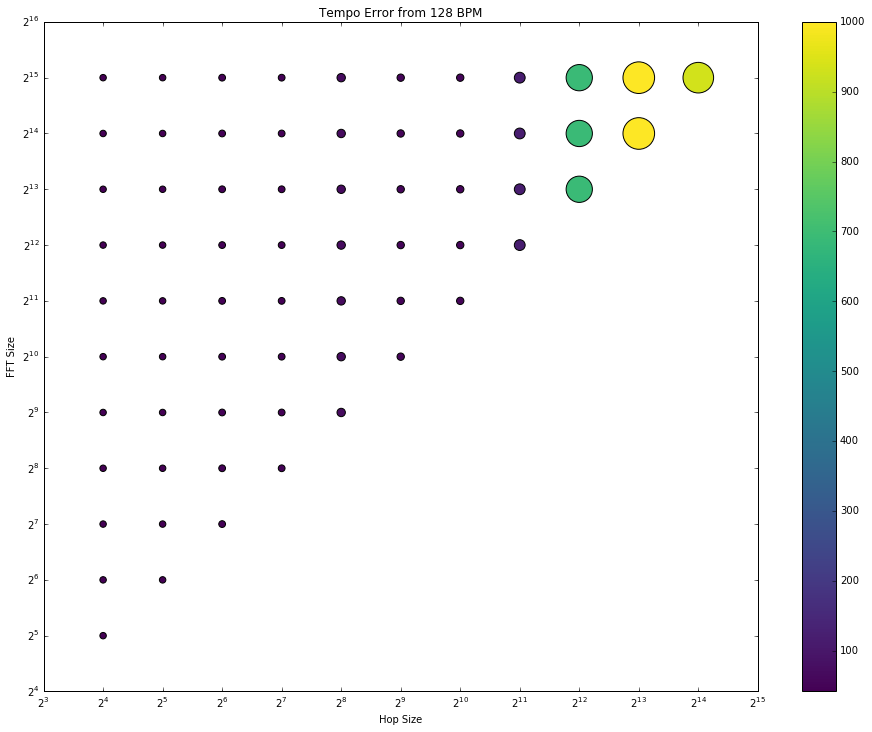

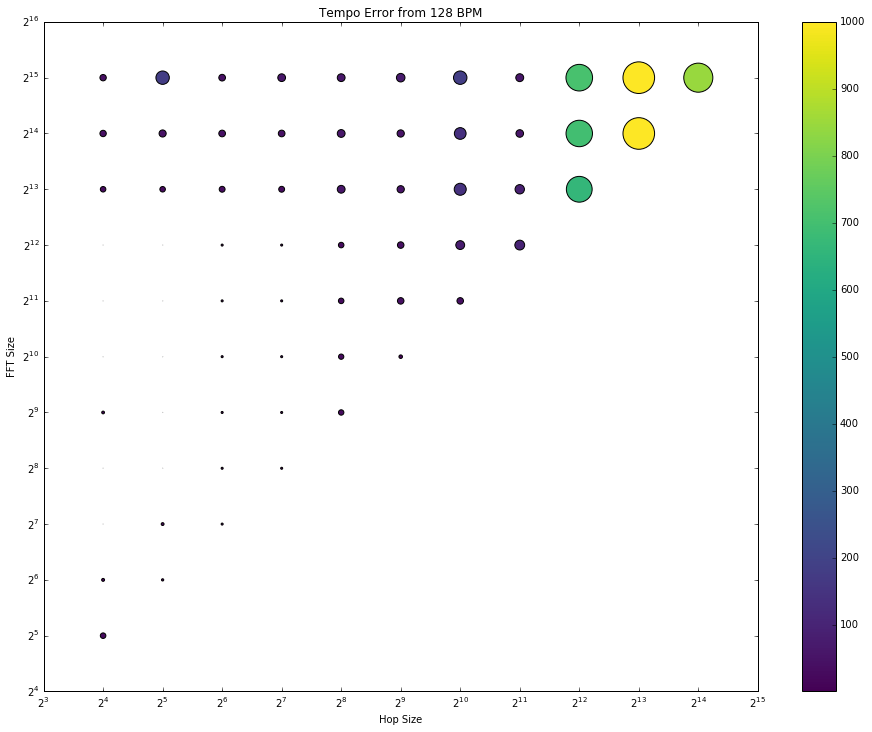

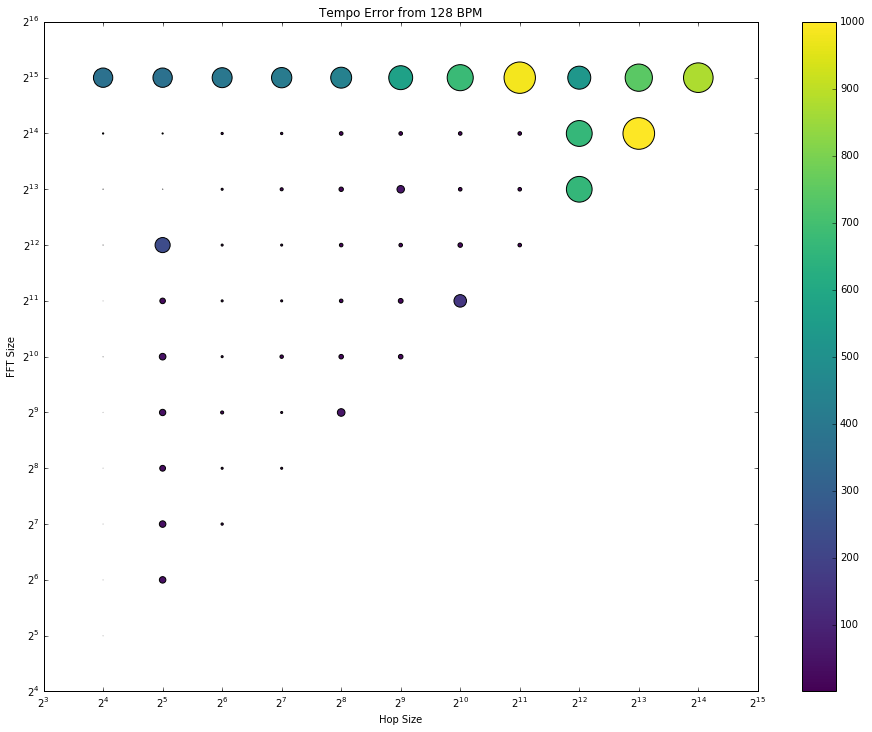

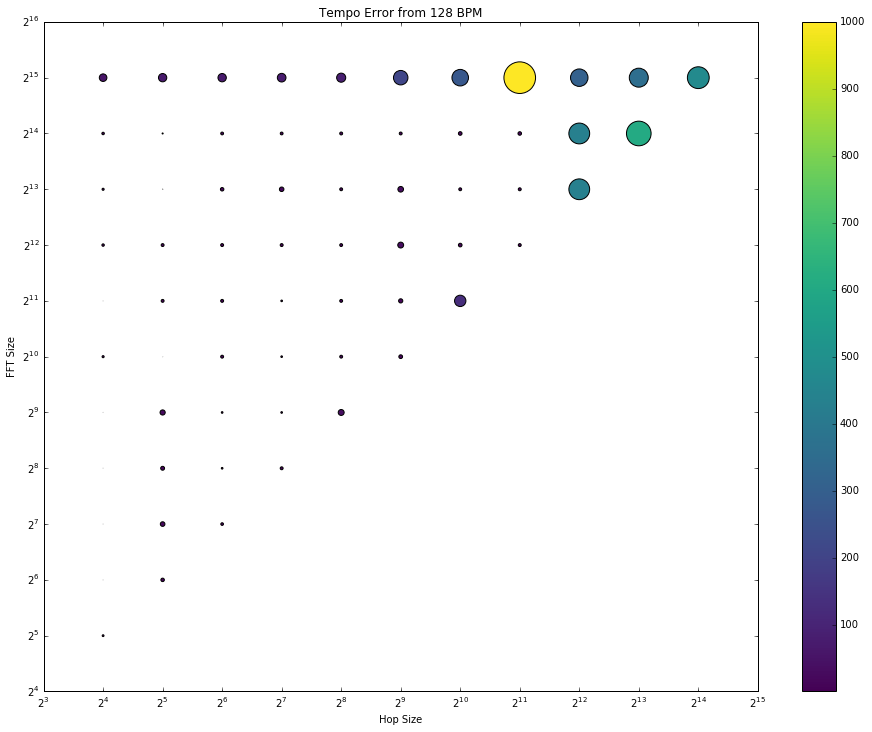

In [9]:
with open('all_files_results.pickle', 'rb') as handle:
     all_files_44_results = pickle.load(handle)

# debug
print(len(all_files_44_results.items()))  # (132, 66, 4) file-index, tempi, (tempo, hpss, SF, SF-hpss)
tempi = all_files_44_results["44_Kick 70s 2.wav"]
print(np.array(tempi).shape)


def plotTempoError(all_files_dict, args, whichTempo):
    
    unzipped_args = list(zip(*args))
    hop = unzipped_args[0]
    fft = unzipped_args[1]

    agg_tempos = []
    agg_tempos_perc = []
    agg_tempos_sf = []
    agg_tempos_sf_perc = []

    for key, value in all_files_dict.items():
        unzipped_results = list(zip(*value))
        tempos      = unzipped_results[0]
        tempos_perc = unzipped_results[1]
        tempos_sf      = unzipped_results[2]
        tempos_sf_perc = unzipped_results[3]
        agg_tempos.append(tempos)
        agg_tempos_perc.append(tempos_perc)
        agg_tempos_sf.append(tempos_sf)
        agg_tempos_sf_perc.append(tempos_sf_perc)
        
    tempo_list = agg_tempos
    if whichTempo == 1:
        tempo_list = agg_tempos
    elif whichTempo == 2:
        tempo_list = agg_tempos_perc
    elif whichTempo == 3:
        tempo_list = agg_tempos_sf
    elif whichTempo == 4:
        tempo_list = agg_tempos_sf_perc

    errors = []
    for x in tempo_list:
        per_file_error = []
        for t in x:
            e = t - 128.0
            per_file_error.append(e)
        errors.append(per_file_error)

    summed_by_args = np.sum(np.abs(errors), axis=0)
    errors = (summed_by_args/np.max(summed_by_args))*1000
    colors = np.arange(np.max(hop))

    fig = plt.figure(figsize=(16, 12))                                                               
    ax = fig.add_subplot(1,1,1) 
    ax.set_xscale('log', basex=2)
    ax.set_yscale('log', basey=2)
    ax.set_xlabel('Hop Size')
    ax.set_ylabel('FFT Size')
    plt.scatter(hop, fft, s=errors, alpha=1.0, c=errors, cmap='viridis')
    plt.colorbar()
    plt.title("Tempo Error from 128 BPM")

#     for i in range(len(args)):
#         print(args[i], summed_by_args[i])
        
plotTempoError(all_files_44_results, args, whichTempo=1)
plotTempoError(all_files_44_results, args, whichTempo=2)
plotTempoError(all_files_44_results, args, whichTempo=3)
plotTempoError(all_files_44_results, args, whichTempo=4)


In [ ]:
print(args)
unzipped_args = list(zip(*args))
hop = unzipped_args[0]
fft = unzipped_args[1]
print(hop)
print(fft)

In [ ]:
ableton_kicks_path = "/home/iorife/github/Investigaciones/Drums/Kick_small/"

# args = [(32, 1024),
#         (512, 2048), 
#         (1024, 4096)]

# Generate a space of hop x fft window size
hop = np.exp2(range(4, 15)).astype(np.int64)
print(hop)
fft = np.exp2(range(5, 16)).astype(np.int64)
print(fft)

args = []
for i in range(len(hop)):
    for j in range(i, len(fft)):
        args.append((hop[i], fft[j]))

bpm = 128
nb_beats = 16
sr = 48000

hop_length = 32
fftsize = 1024

all_files_results = []

for kick_sample in os.listdir(ableton_kicks_path):
    if kick_sample.endswith('.wav'):
        kick_sample_path = os.path.join(ableton_kicks_path, kick_sample)
        print("\nAnalysing " + kick_sample_path)
        kick_sample, sr = librosa.load(kick_sample_path, mono=True, sr=sr)
        y = riddim_utils.createFourOnTheFloor(bpm=bpm, nb_beats=nb_beats, sr=sr, sample=kick_sample)
        
        # once we have y, compute tempo with a variety of analysis params
        results = [computeTempo(y, sr, hop, fft) for hop, fft in args]
        all_files_results.append(results)

In [ ]:
all_files_results = np.load('all_files_results.npy')

print(np.array(all_files_results).shape) # (132, 66, 2) file-index, tempos, (librosa vs hpss)
def plotTempoError(all_files_results, args):
    
    unzipped_args = zip(*args)
    hop = unzipped_args[0]
    fft = unzipped_args[1]

    agg_tempos = []
    agg_tempos_perc = []
    for one_file_results in all_files_results:
        unzipped_results = zip(*one_file_results)
        tempos      = unzipped_results[0]
        tempos_perc = unzipped_results[1]
        agg_tempos.append(tempos)
        agg_tempos_perc.append(tempos_perc)
    
    flattened_tempos      = np.array(agg_tempos).flatten()
    flattened_tempos_perc = np.array(agg_tempos_perc).flatten()

    fig = plt.figure(figsize=(15, 10))                                                               
    ax = fig.add_subplot(1,1,1) 
    ax.hist((flattened_tempos, flattened_tempos_perc), 20, log=True)
    plt.title("Tempo distribution")

        
plotTempoError(all_files_results, args)

In [ ]:
# librosa SuperFlux

fftsize = 1024
hop_length = 128
lag = 2
n_mels = 138
fmin = 27.5
fmax = 16000.
max_size = 3
sr = 48000

y, sr = librosa.load('/Users/iorife/github/Investigaciones/4-on-floor-output.wav', mono=True, sr=sr)
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=fftsize, hop_length=hop_length,
                                   fmin=fmin, fmax=fmax, n_mels=n_mels)
odf_sf = librosa.onset.onset_strength(S=librosa.logamplitude(S), sr=sr,hop_length=hop_length, 
                                      lag=lag, max_size=max_size)
onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf, sr=sr, hop_length=hop_length)
librsoa_tempo_sf_perc, librosa_beat_frames = librosa.beat.beat_track(onset_envelope=odf_sf, 
                                                                     sr=sr, 
                                                                     hop_length=hop_length)
print(librsoa_tempo_sf_perc)


plt.figure(figsize=(12, 8))
plt.plot(odf_sf, color='g', label='Superflux')
plt.vlines(onset_sf, 0, odf_sf.max(), color='r', label='Onsets')
plt.xticks([])
plt.yticks([])
plt.legend()
plt.axis('tight')

plt.tight_layout()
plt.show()

In [ ]:
# madmom SuperFlux
class SuperFluxProcessor(madmom.processors.SequentialProcessor):
    
    def __init__(self, num_bands=24, diff_max_bins=3, positive_diffs=True):
        # define the processing chain
        spec = madmom.audio.spectrogram.LogarithmicFilteredSpectrogramProcessor(num_bands=num_bands)
        diff = madmom.audio.spectrogram.SpectrogramDifferenceProcessor(diff_max_bins=diff_max_bins,
                                                                       positive_diffs=positive_diffs)
        from functools import partial
        mean = partial(np.mean, axis=1)
        # sequentially process everything
        super(SuperFluxProcessor, self).__init__([spec, diff, mean])
        

superflux_5 = SuperFluxProcessor().process('/Users/iorife/github/Investigaciones/4-on-floor-output.wav')